**Imports**

In [3]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import saraRC1 as sara

seg_dim = 8

**Multi-Plot**

In [4]:
ranges = list(zip(np.arange(1, 7000, 100), np.arange(100, 7100, 100)))
ranges = [list(t) for t in ranges]
ranges[0][0] = 0

In [5]:
ranges

[[0, 100],
 [101, 200],
 [201, 300],
 [301, 400],
 [401, 500],
 [501, 600],
 [601, 700],
 [701, 800],
 [801, 900],
 [901, 1000],
 [1001, 1100],
 [1101, 1200],
 [1201, 1300],
 [1301, 1400],
 [1401, 1500],
 [1501, 1600],
 [1601, 1700],
 [1701, 1800],
 [1801, 1900],
 [1901, 2000],
 [2001, 2100],
 [2101, 2200],
 [2201, 2300],
 [2301, 2400],
 [2401, 2500],
 [2501, 2600],
 [2601, 2700],
 [2701, 2800],
 [2801, 2900],
 [2901, 3000],
 [3001, 3100],
 [3101, 3200],
 [3201, 3300],
 [3301, 3400],
 [3401, 3500],
 [3501, 3600],
 [3601, 3700],
 [3701, 3800],
 [3801, 3900],
 [3901, 4000],
 [4001, 4100],
 [4101, 4200],
 [4201, 4300],
 [4301, 4400],
 [4401, 4500],
 [4501, 4600],
 [4601, 4700],
 [4701, 4800],
 [4801, 4900],
 [4901, 5000],
 [5001, 5100],
 [5101, 5200],
 [5201, 5300],
 [5301, 5400],
 [5401, 5500],
 [5501, 5600],
 [5601, 5700],
 [5701, 5800],
 [5801, 5900],
 [5901, 6000],
 [6001, 6100],
 [6101, 6200],
 [6201, 6300],
 [6301, 6400],
 [6401, 6500],
 [6501, 6600],
 [6601, 6700],
 [6701, 6800],
 

In [6]:
ranges[0]

[0, 100]

In [7]:
img_path = './Siris Dataset/ASSR/images/train/'
imgs = {}

i = 0
experiment = 1
range_ = ranges[experiment - 1]

for root, dirs, files in os.walk(img_path):
    for file in files[range_[0]:range_[1]]:
        file_name = file.split('.')[0]
        imgs[file_name] = cv2.cvtColor(cv2.imread(os.path.join(root, file)), cv2.COLOR_BGR2RGB)
        i += 1

In [49]:
mask_path = './Siris Dataset/ASSR/gt/train/'
# masks = {}
gt_masks = {}
gt_ranks = {}

for file_name in imgs:
    gt_ranks[file_name] = {}
    
    file = file_name + '.png'
    mask = cv2.cvtColor(cv2.imread(os.path.join(mask_path, file)), cv2.COLOR_BGR2GRAY)
    # masks[file_name] = cv2.cvtColor(cv2.imread(os.path.join(mask_path, file)), cv2.COLOR_BGR2GRAY)
    # Separate the mask based on colour
    # masks[file_name] = {}
    gt_masks[file_name] = {}

    # Detect different colours in mask
    # Create histogram
    hist = cv2.calcHist([mask], [0], None, [256], [0, 256])

    # Show non-zero values and extract intensity values at that freq
    non_zero = np.nonzero(hist)
    x = non_zero[0][1:]

    # Separate mask into regions which match the intensity values in x
    for i, intensity in enumerate(reversed(x)):
        # masks[file_name][i] = np.where(mask == intensity, 1, 0)
        gt_masks[file_name][i] = np.where(mask == intensity, 1, 0)
        
        # Calculate ranks based on highest intensity
        gt_ranks[file_name][i] = i + 1


**MASK R-CNN**

In [9]:
# Root directory of the project
ROOT_DIR = os.path.abspath("./")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
import coco

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

c:\Users\matth\anaconda3\envs\coco\lib\site-packages\tensorflow\python\framework\dtypes.py:458: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\Users\matth\anaconda3\envs\coco\lib\site-packages\tensorflow\python\framework\dtypes.py:459: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\Users\matth\anaconda3\envs\coco\lib\site-packages\tensorflow\python\framework\dtypes.py:460: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\Users\matth\anaconda3\envs\coco\lib\site-packages\tensorflow\python\frame

In [10]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [12]:
import tensorflow as tf
import keras
import h5py
print(tf.__version__)
print(keras.__version__)
print(h5py.__version__)

# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

masks = {}

for file_name in imgs:
    # Run detection
    results = model.detect([imgs[file_name]], verbose=1)

    # Visualize results
    r = results[0]
    visualize.display_instances(imgs[file_name], r['rois'], r['masks'], r['class_ids'], 
                                class_names, r['scores'])


    masks[file_name] = {}
    
    for i in range(len(results[0]['class_ids'])):
        masks[file_name][i] = np.array(results[0]['masks'][:, :, i], dtype=np.uint8) * 255

1.3.0
2.0.8
2.10.0
Processing 1 images
image                    shape: (480, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


KeyboardInterrupt: 

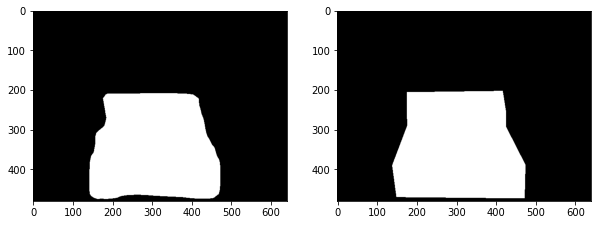

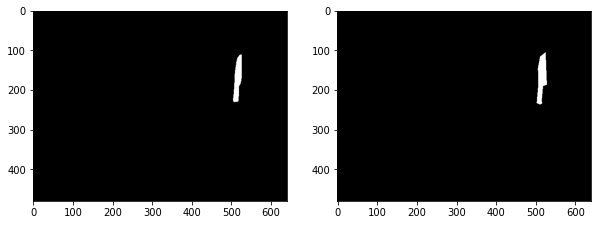

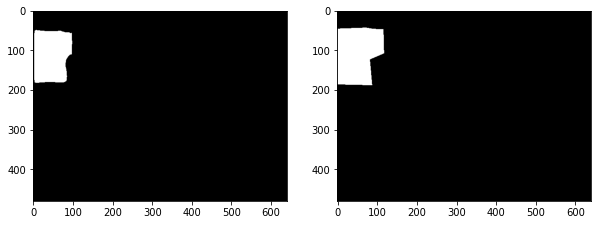

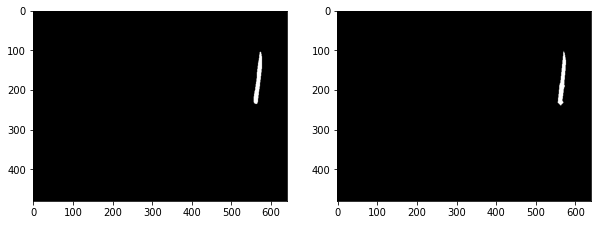

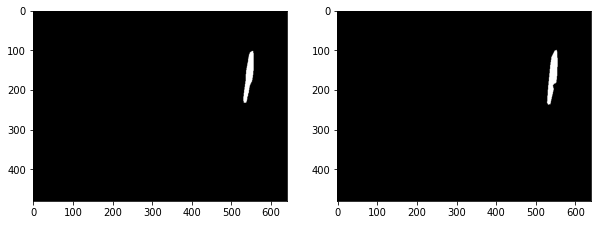

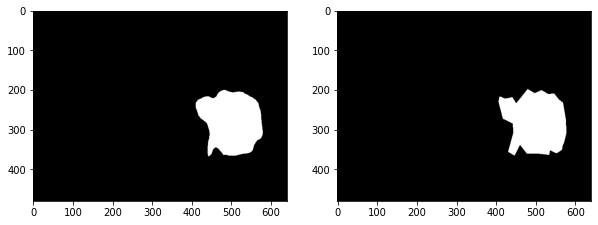

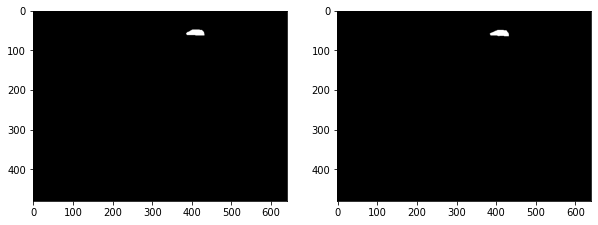

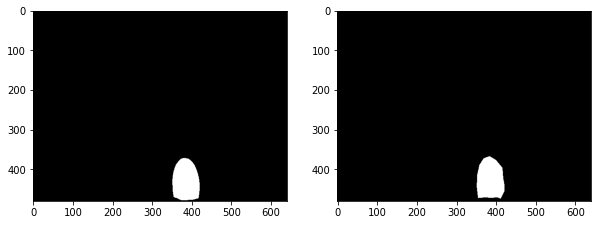

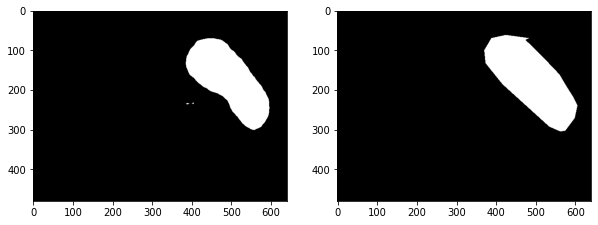

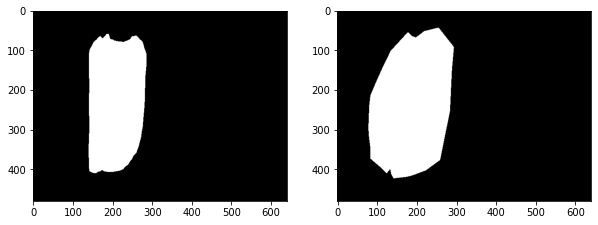

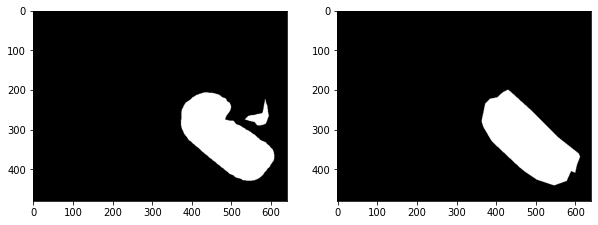

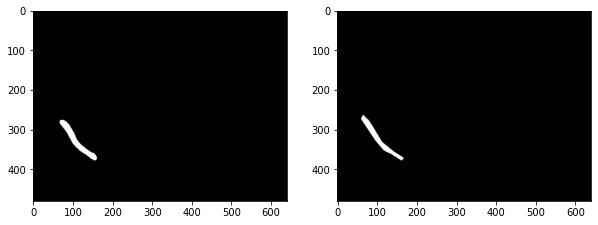

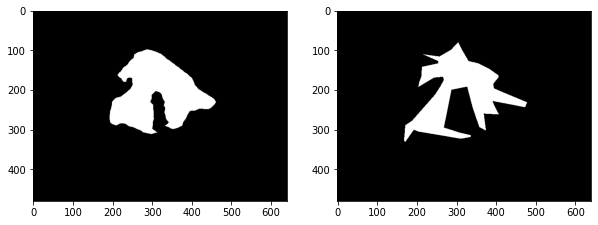

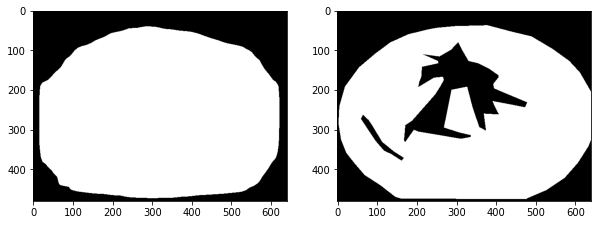

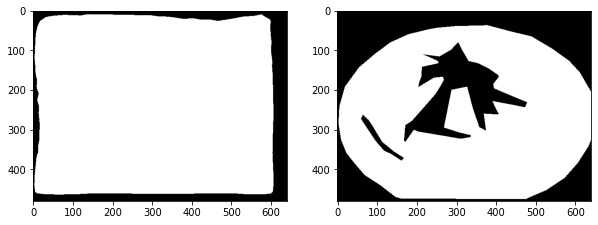

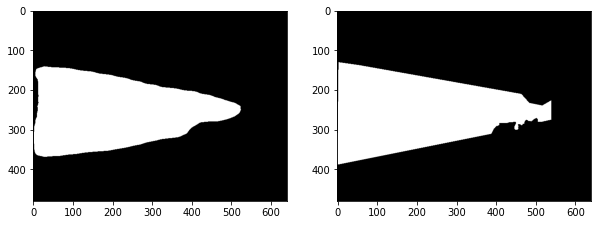

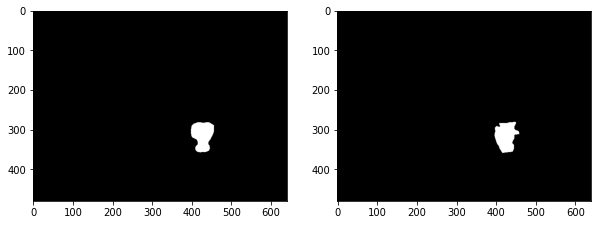

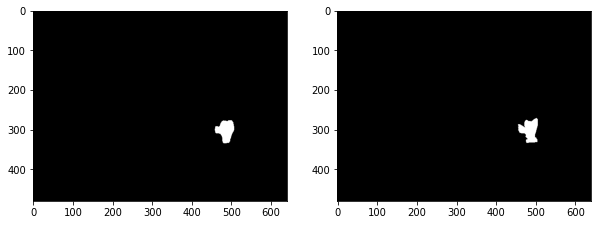

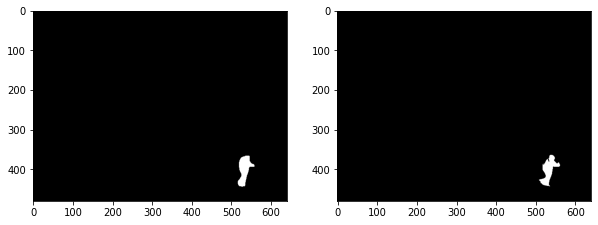

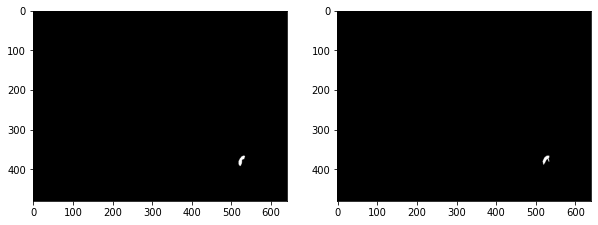

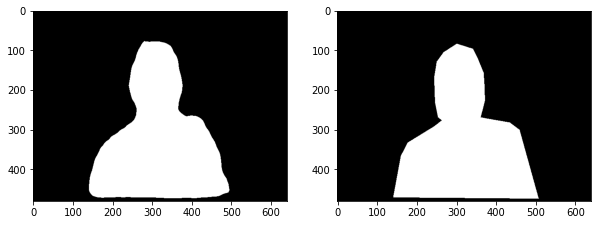

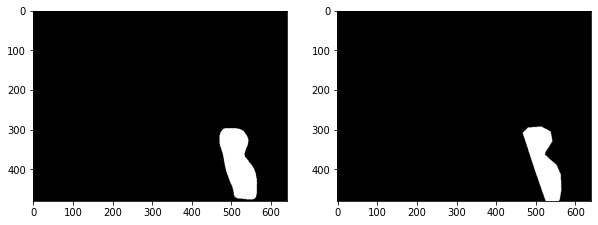

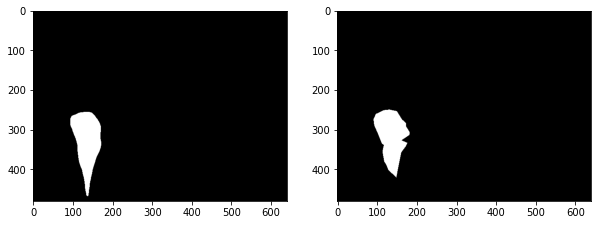

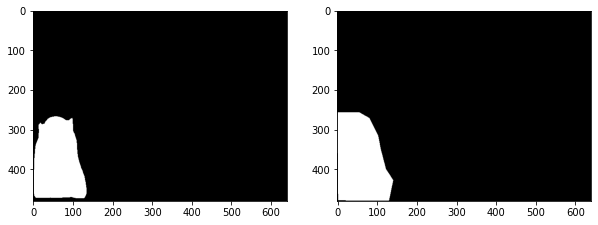

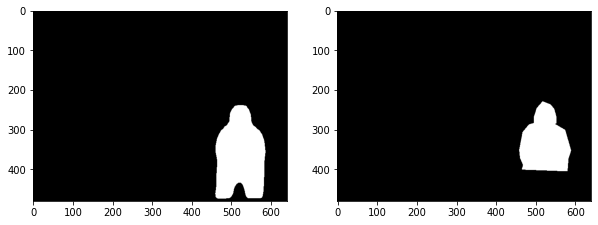

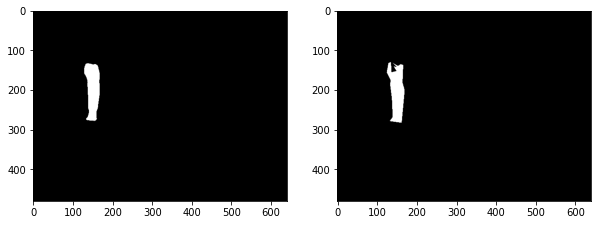

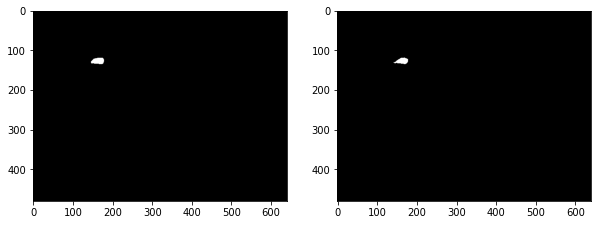

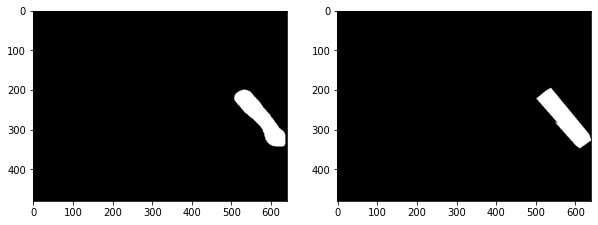

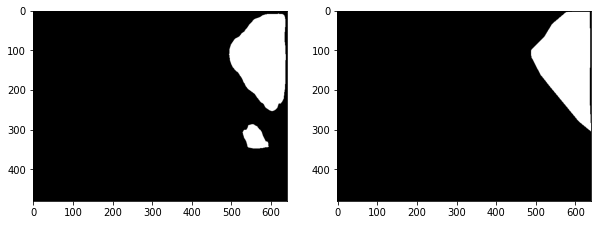

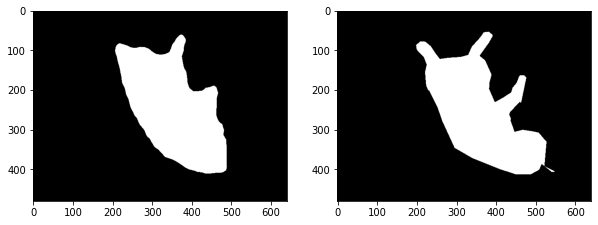

In [50]:
# Match masks generated to Mask RCNN to ground truth masks

masks_valid = {}
gt_masks_valid = {}
gt_ranks_valid = {}

for file_name in masks:
    masks_valid[file_name] = {}
    gt_masks_valid[file_name] = {}
    gt_ranks_valid[file_name] = {}
    
    for mask in masks[file_name]:
        best_iou = 0
        for gt_mask in gt_masks[file_name]:
            # Calculate IoU
            intersection = np.logical_and(masks[file_name][mask], gt_masks[file_name][gt_mask])
            union = np.logical_or(masks[file_name][mask], gt_masks[file_name][gt_mask])
            iou_score = np.sum(intersection) / np.sum(union)

            if iou_score > 0.5 and iou_score > best_iou:
                best_iou = iou_score
                masks_valid[file_name][mask] = masks[file_name][mask]
                gt_masks_valid[file_name][mask] = gt_masks[file_name][gt_mask]
                gt_ranks_valid[file_name][mask] = gt_ranks[file_name][gt_mask]

        # fig, ax = plt.subplots(1, 2, figsize=(10, 10))
        # ax[0].imshow(masks_valid[file_name][mask], cmap='gray')
        # ax[1].imshow(gt_masks_valid[file_name][mask], cmap='gray')
        # plt.show()


# Delete empty masks


In [51]:
masks = gt_masks

In [52]:
masks = masks_valid
gt_masks = gt_masks_valid
gt_ranks = gt_ranks_valid

In [53]:
masks

{'COCO_train2014_000000000009': {},
 'COCO_train2014_000000000089': {0: array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
  1: array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
  2: array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
  3: array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]], dty

In [17]:
# Save to pickle
import pickle

with open('masks.pkl', 'wb') as f:
    pickle.dump(masks, f)

In [46]:
# Load from pickle
import pickle

with open('masks.pkl', 'rb') as f:
    masks = pickle.load(f)

In [19]:
gt_ranks

{}

**Saliency Maps/Heatmaps/Rankings**

In [20]:
seg_dim = 8
saliency_maps = {}
sara_heatmaps = {}
sara_lists = {}

In [23]:
from time import time

plt.rcParams['figure.figsize'] = [20, 10]
plt.figure()
plt.tight_layout()

# generators = ['itti', 'deepgaze', 'fpn', 'emlnet']
generators = ['itti', 'deepgaze']

g = 1

# DeepGaze
import deepgaze_pytorch
DEVICE = 'cpu'
model = deepgaze_pytorch.DeepGazeIIE(pretrained=True).to(DEVICE)

# EML-NET
# from emlnet import resnet
# from emlnet import decoder
# from emlnet import SaliconLoader

# image_model_path = 'emlnet/backbone/res_imagenet.pth'
# place_model_path = 'emlnet/backbone/res_places.pth'
# decoder_model_path = 'emlnet/backbone/res_decoder.pth'
# size = (480, 640)
# num_feat = 5

# img_model = resnet.resnet50(image_model_path).eval()
# pla_model = resnet.resnet50(place_model_path).eval()
# decoder_model = decoder.build_decoder(decoder_model_path, size, num_feat, num_feat).eval()

# emlnet_models = [img_model, pla_model, decoder_model]


for i, im in enumerate(imgs):
    start = time()

    if im not in saliency_maps:
        saliency_maps[im] = {}
        sara_heatmaps[im] = {}
        sara_lists[im] = {}

    for generator in generators:
        percent = round(g/(len(imgs)*len(generators))*100, 2)
        
        print(f'--> Processing image {i+1} of {len(imgs)} ({generator}) [{percent}%]')

        saliency_maps[im][generator] = sara.return_saliency(imgs[im].copy(), generator=generator, deepgaze_model=model)
        sara.reset()

        sara_heatmaps[im][generator], sara_lists[im][generator] = sara.return_sara(imgs[im].copy(), seg_dim, saliency_map=saliency_maps[im][generator])
        sara.reset()

        g += 1
    
    print(f'Time for image {i + 1}: {time() - start} seconds')


Loaded pretrained weights for efficientnet-b5


Using cache found in C:\Users\matth/.cache\torch\hub\pytorch_vision_v0.6.0
Using cache found in C:\Users\matth/.cache\torch\hub\pytorch_vision_v0.6.0


KeyboardInterrupt: 

<Figure size 1440x720 with 0 Axes>

In [ ]:
# Save to pickle
import pickle

with open('saliency_maps.pkl', 'wb') as f:
    pickle.dump(saliency_maps, f)

with open('sara_heatmaps.pkl', 'wb') as f:
    pickle.dump(sara_heatmaps, f)

with open('sara_lists.pkl', 'wb') as f:
    pickle.dump(sara_lists, f)

In [57]:
# Load from pickle
import pickle

with open('saliency_maps.pkl', 'rb') as f:
    saliency_maps = pickle.load(f)

with open('sara_heatmaps.pkl', 'rb') as f:
    sara_heatmaps = pickle.load(f)

with open('sara_lists.pkl', 'rb') as f:
    sara_lists = pickle.load(f)

**<h2>Mask Ranking</h2>**

In [25]:
T = 0.001

In [26]:
def index_to_coordinates(index, seg_dim, im_size):
    '''
    Given an index and a shape, this function returns the corresponding coordinates.
    '''

    x1 = int((index % seg_dim) * (im_size[1] / seg_dim))
    y1 = int((index // seg_dim) * (im_size[0] / seg_dim))

    x2 = int(x1 + (im_size[1] / seg_dim))
    y2 = int(y1 + (im_size[0] / seg_dim))
    
    return (x1, y1, x2, y2)

In [58]:
# For each segment, check which mask falls under that segment using MRn = rank(Gi); (Gi interesect Mn) > T
mask_segments = {}

for sara_list in sara_lists:
    for segment in sara_lists[sara_list]['deepgaze']:
        if sara_list not in mask_segments:
            mask_segments[sara_list] = {}

        # Convert index to coordinates, extract segment from heatmap
        shape = sara_heatmaps[sara_list]['deepgaze'].shape[0:2]
        x1, y1, x2, y2 = index_to_coordinates(segment[5], seg_dim, shape)
        # print(x1, y1, x2, y2)

        for m in masks[sara_list]:
            if m not in mask_segments[sara_list]:
                mask_segments[sara_list][m] = []

            # Extract mask from masks
            mask = masks[sara_list][m][y1:y2, x1:x2]

            # Calculate intersection over union
            intersection = np.sum(mask > 0)
            union = np.sum(mask > 0) + np.sum(mask == 0)

            iou = intersection / union

            # print('Segment: ', segment[5], 'Mask: ', m, 'IoU: ', iou)

            if iou > T:
                # index, rank, saliency
                # print(segment)
                mask_segments[sara_list][m].append((segment[5], segment[0], segment[1]))
                # print(mask_segments)

KeyError: 'COCO_train2014_000000371608'

In [ ]:
mask_segments.keys()

dict_keys(['COCO_train2014_000000000009', 'COCO_train2014_000000000089', 'COCO_train2014_000000000307', 'COCO_train2014_000000000321', 'COCO_train2014_000000000332', 'COCO_train2014_000000000349', 'COCO_train2014_000000000382', 'COCO_train2014_000000000389', 'COCO_train2014_000000000419', 'COCO_train2014_000000000443'])

In [ ]:
# For each mask, find the segment with the lowest rank
mask_segments_min = {}

for sara_list in mask_segments:
    for m in mask_segments[sara_list]:
        # mask_segments_min[sara_list][m] = min(mask_segments[sara_list][m], key=lambda x: x[1])[0]
        if sara_list not in mask_segments_min:
            mask_segments_min[sara_list] = {}
        
        mask_segments_min[sara_list][m] = min(mask_segments[sara_list][m], key=lambda x: x[1])

mask_segments_min

{'COCO_train2014_000000371608': {0: (62, 3, 96203.95549966901),
  1: (44, 9, 4203497955649267.5),
  2: (35, 0, 5.465739918157056e+19),
  3: (50, 10, 13044932240053.236),
  4: (47, 14, 600578136698958.0)},
 'COCO_train2014_000000530869': {0: (35, 0, 7430595993542621.0),
  1: (52, 14, 46246075313.05125),
  2: (44, 40, 25396187013719.344),
  3: (52, 14, 46246075313.05125)},
 'COCO_train2014_000000491492': {0: (38, 1, 608256225304712.0),
  1: (44, 21, 8932527032829.305),
  2: (21, 20, 6.326901948205368e+23),
  3: (18, 11, 9.720076806628705e+24),
  4: (33, 50, 6.162530083261621e+16)},
 'COCO_train2014_000000253229': {0: (13, 3, 1.2960719715741298e+33),
  1: (34, 1, 7.224818296100634e+17),
  2: (20, 4, 1.6556589640697026e+27),
  3: (13, 3, 1.2960719715741298e+33),
  4: (10, 6, 1.5284088588202864e+36)},
 'COCO_train2014_000000015427': {0: (61, 1, 1699580.8782406147),
  1: (33, 6, 9.752655817453736e+23),
  2: (62, 0, 912813.6226803449),
  3: (20, 34, 7.724692464397094e+31),
  4: (53, 39, 94896

In [ ]:
mask_ranks = {}

for sara_list in mask_segments_min:
    mask_ranks[sara_list] = {}
    # Extract the ranks and sort them by the third value in each tuple
    sorted_ranks = sorted(mask_segments_min[sara_list].items(), key=lambda x: x[1][1])

    for i in range(len(sorted_ranks)):
        mask_ranks[sara_list][sorted_ranks[i][0]] = i + 1

    # Sort mask_ranks[sara_list] by object
    mask_ranks[sara_list] = {k: v for k, v in sorted(mask_ranks[sara_list].items(), key=lambda item: item[0])}

In [ ]:
mask_ranks

{'COCO_train2014_000000371608': {0: 2, 1: 3, 2: 1, 3: 4, 4: 5},
 'COCO_train2014_000000530869': {0: 1, 1: 2, 2: 4, 3: 3},
 'COCO_train2014_000000491492': {0: 1, 1: 4, 2: 3, 3: 2, 4: 5},
 'COCO_train2014_000000253229': {0: 2, 1: 1, 2: 4, 3: 3, 4: 5},
 'COCO_train2014_000000015427': {0: 2, 1: 3, 2: 1, 3: 4, 4: 5},
 'COCO_train2014_000000192799': {0: 1, 1: 2},
 'COCO_train2014_000000086790': {0: 1, 1: 4, 2: 2, 3: 3, 4: 5},
 'COCO_train2014_000000350701': {0: 1, 1: 2, 2: 3, 3: 4, 4: 5},
 'COCO_train2014_000000534633': {0: 2, 1: 3, 2: 1, 3: 5, 4: 4},
 'COCO_train2014_000000190573': {0: 3, 1: 1, 2: 2, 3: 4},
 'COCO_train2014_000000050961': {0: 3, 1: 4, 2: 1, 3: 2},
 'COCO_train2014_000000178285': {0: 1, 1: 2},
 'COCO_train2014_000000032816': {0: 1, 1: 3, 2: 5, 3: 2, 4: 4},
 'COCO_train2014_000000389932': {0: 1, 1: 5, 2: 2, 3: 4, 4: 3},
 'COCO_train2014_000000304332': {0: 1, 1: 2, 2: 3},
 'COCO_train2014_000000023098': {0: 1, 1: 2, 2: 3, 3: 4},
 'COCO_train2014_000000457087': {0: 1, 1: 4, 2: 

**<h2>Spearman Correlation (Metric for Ranks)</h2>**

In [ ]:
list(mask_ranks['COCO_train2014_000000000009'].values())

KeyError: 'COCO_train2014_000000000009'

In [ ]:
import scipy.stats as sc

all_spr = 0

for sara_list in mask_ranks:
    print(f'PR: {list(mask_ranks[sara_list].values())}\nGT: {list(gt_ranks[sara_list].values())}')
    try:
        spr = sc.spearmanr(list(mask_ranks[sara_list].values()), list(gt_ranks[sara_list].values()))
        all_spr += spr.correlation
    except:
        pass
    print()

print(f'Average SPR: {all_spr / len(mask_ranks)}')

PR: [2, 3, 1, 4, 5]
GT: [1, 2, 3, 4, 5]

PR: [1, 2, 4, 3]
GT: [1, 2, 3, 4]

PR: [1, 4, 3, 2, 5]
GT: [1, 2, 3, 4, 5]

PR: [2, 1, 4, 3, 5]
GT: [1, 2, 3, 4, 5]

PR: [2, 3, 1, 4, 5]
GT: [1, 2, 3, 4, 5]

PR: [1, 2]
GT: [1, 2]

PR: [1, 4, 2, 3, 5]
GT: [1, 2, 3, 4, 5]

PR: [1, 2, 3, 4, 5]
GT: [1, 2, 3, 4, 5]

PR: [2, 3, 1, 5, 4]
GT: [1, 2, 3, 4, 5]

PR: [3, 1, 2, 4]
GT: [1, 2, 3, 4]

PR: [3, 4, 1, 2]
GT: [1, 2, 3, 4]

PR: [1, 2]
GT: [1, 2]

PR: [1, 3, 5, 2, 4]
GT: [1, 2, 3, 4, 5]

PR: [1, 5, 2, 4, 3]
GT: [1, 2, 3, 4, 5]

PR: [1, 2, 3]
GT: [1, 2, 3]

PR: [1, 2, 3, 4]
GT: [1, 2, 3, 4]

PR: [1, 4, 2, 5, 3]
GT: [1, 2, 3, 4, 5]

PR: [1, 5, 2, 3, 4]
GT: [1, 2, 3, 4, 5]

PR: [1, 5, 4, 2, 3]
GT: [1, 2, 3, 4, 5]

PR: [4, 3, 2, 1, 5]
GT: [1, 2, 3, 4, 5]

PR: [1, 3, 2, 4, 5]
GT: [1, 2, 3, 4, 5]

PR: [2, 1]
GT: [1, 2]

PR: [4, 3, 2, 5, 1]
GT: [1, 2, 3, 4, 5]

PR: [1, 3, 4, 2, 5]
GT: [1, 2, 3, 4, 5]

PR: [1, 2]
GT: [1, 2]

PR: [2, 4, 1, 3, 5]
GT: [1, 2, 3, 4, 5]

PR: [4, 3, 2, 1, 5]
GT: [1, 2, 3, 4, 5]

P

**<h2>Normalizing Spearman Correlation</h2>**

In [ ]:
def get_norm_spr(spr_value):
    #       m - r_min
    # m -> ---------------- x (t_max - t_min) + t_min
    #       r_max - r_min
    #
    # m = measure value
    # r_min = min range of measurement
    # r_max = max range of measurement
    # t_min = min range of desired scale
    # t_max = max range of desired scale

    r_min = -1
    r_max = 1

    norm_spr = (spr_value - r_min) / (r_max - r_min)

    return norm_spr

In [ ]:
norm_spr = get_norm_spr(spr.correlation)
print(norm_spr)

0.75


**<h2>Mean Absolute Error</h2>**

In [ ]:
def mae(pred, gt):
    return np.mean(np.abs(pred - gt))

/home/matthewkenely/anaconda3/envs/sara/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


Average /mae: 0.0


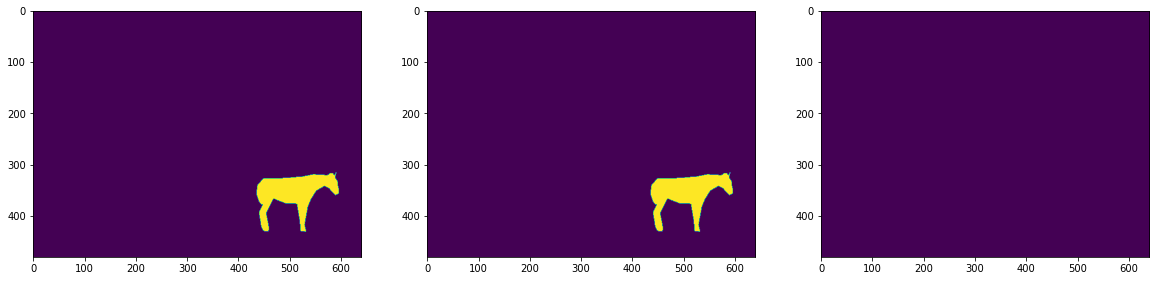

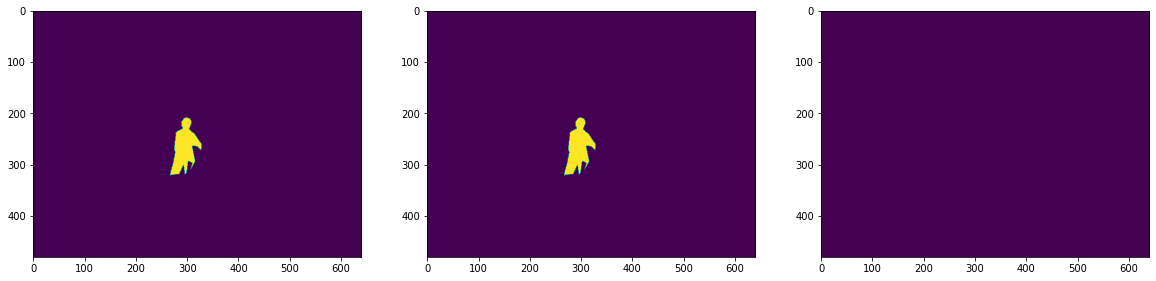

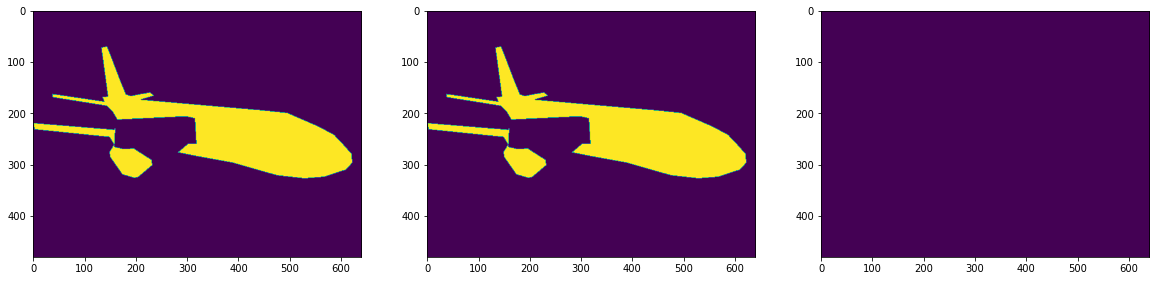

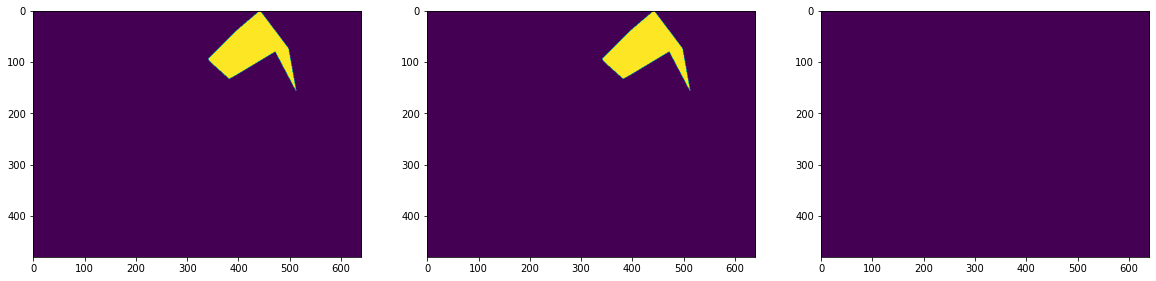

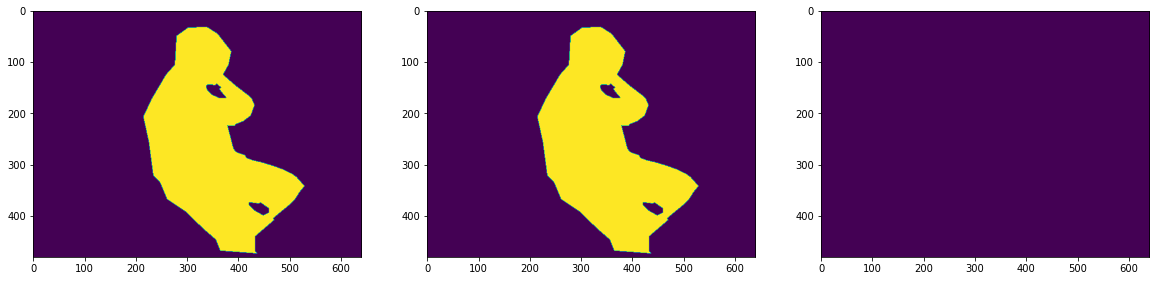

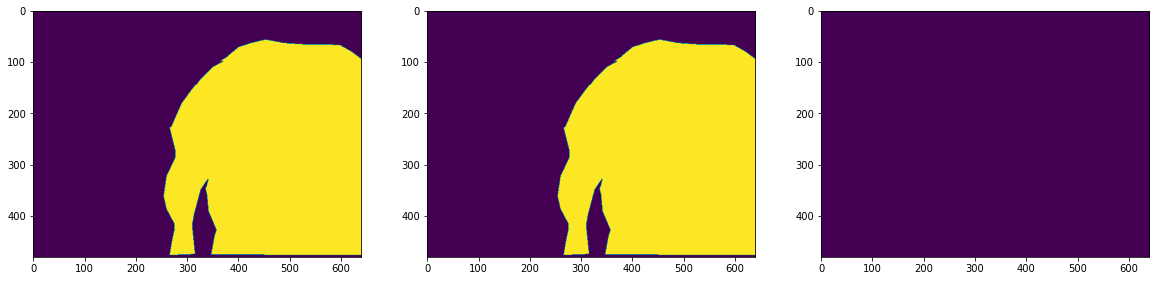

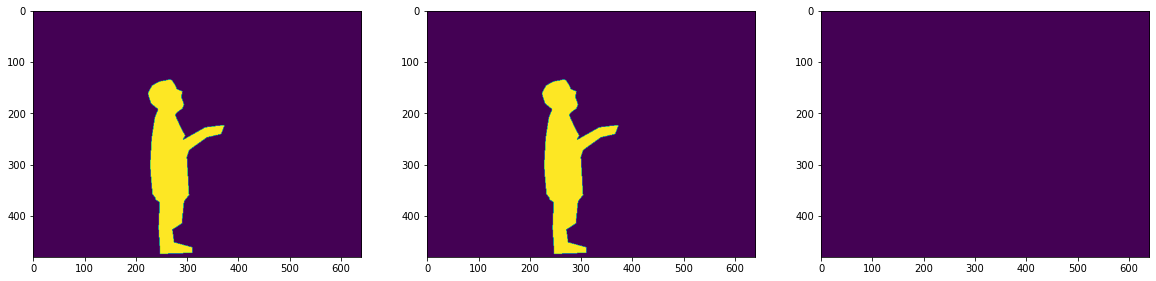

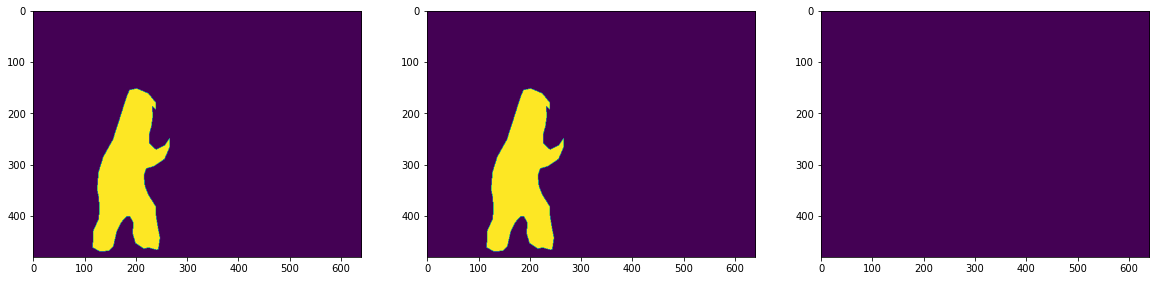

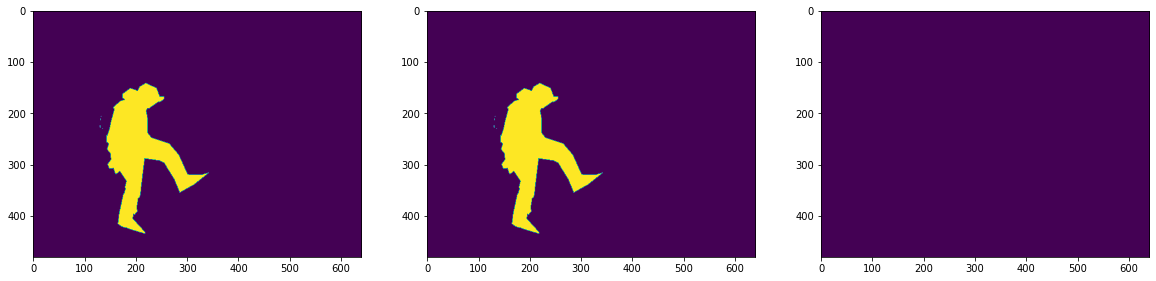

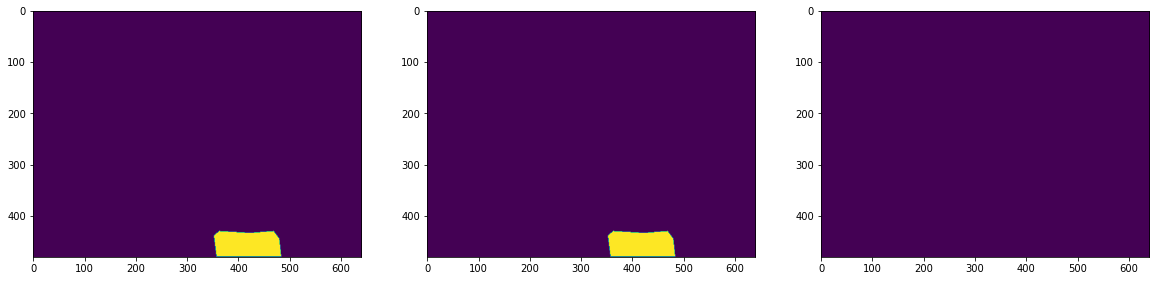

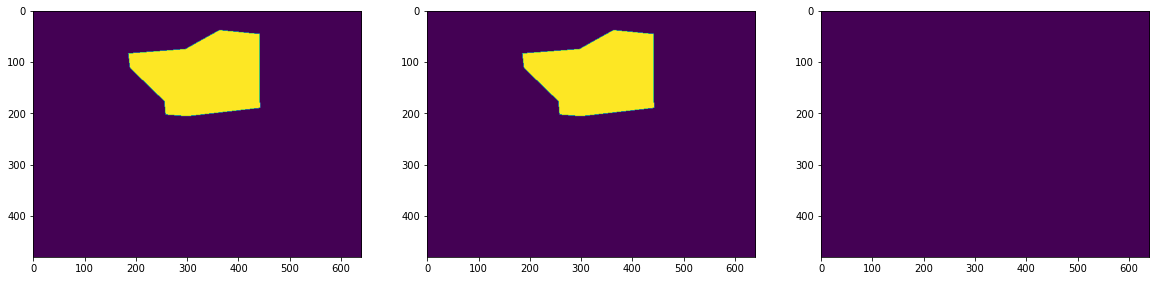

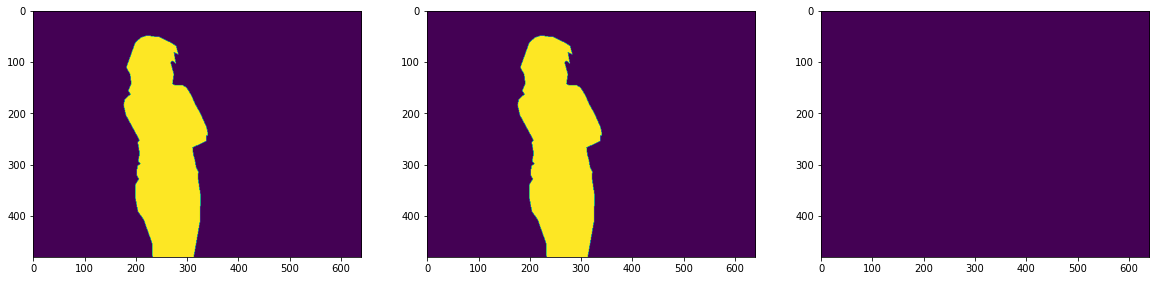

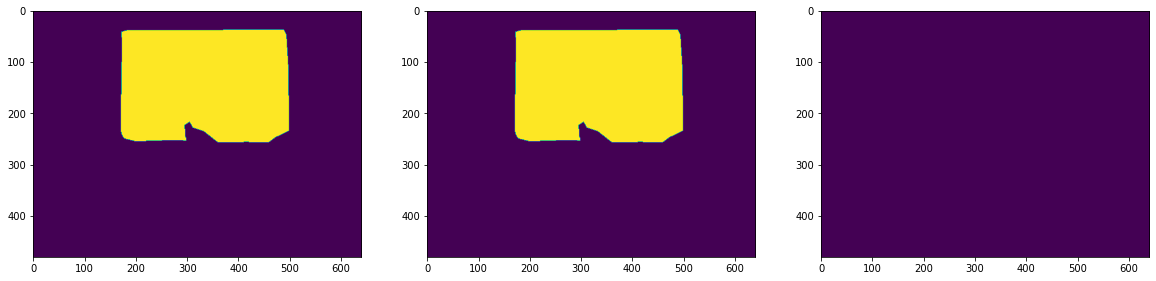

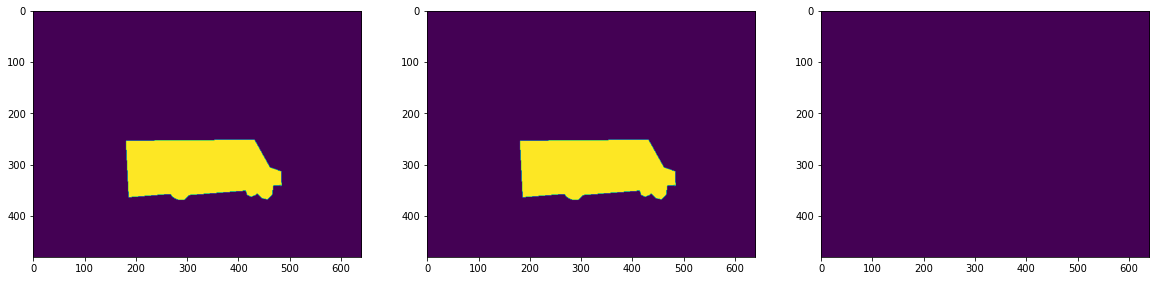

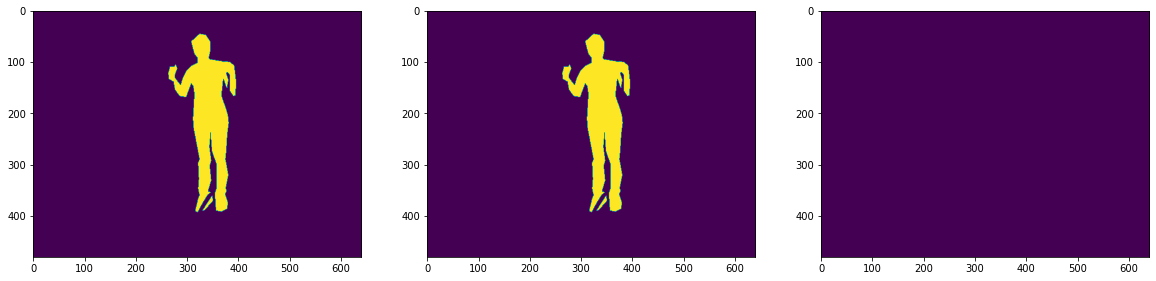

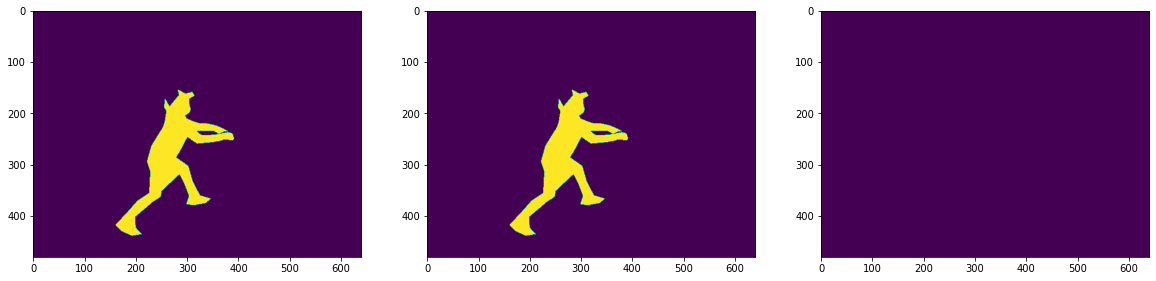

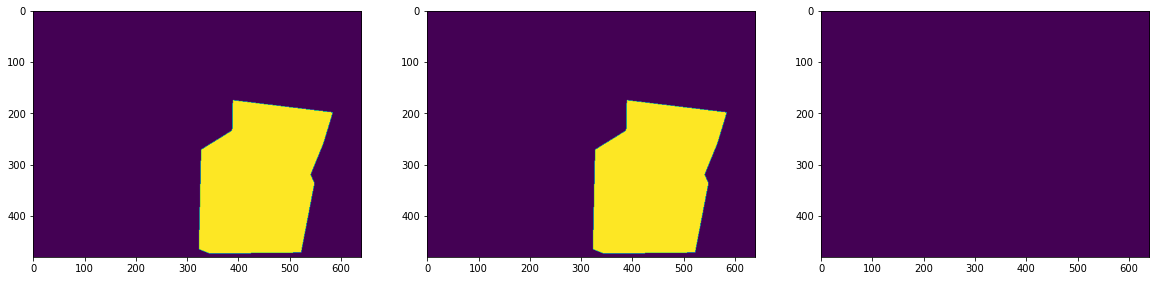

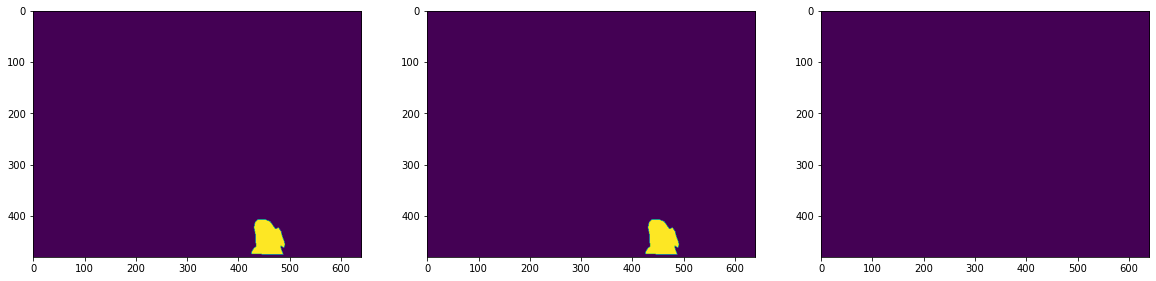

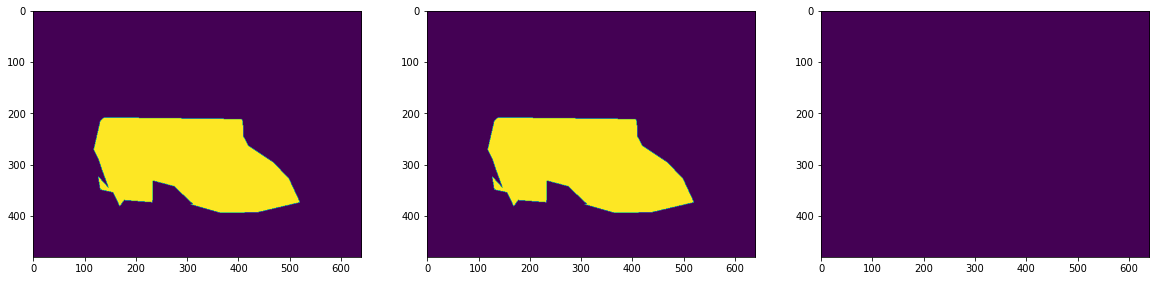

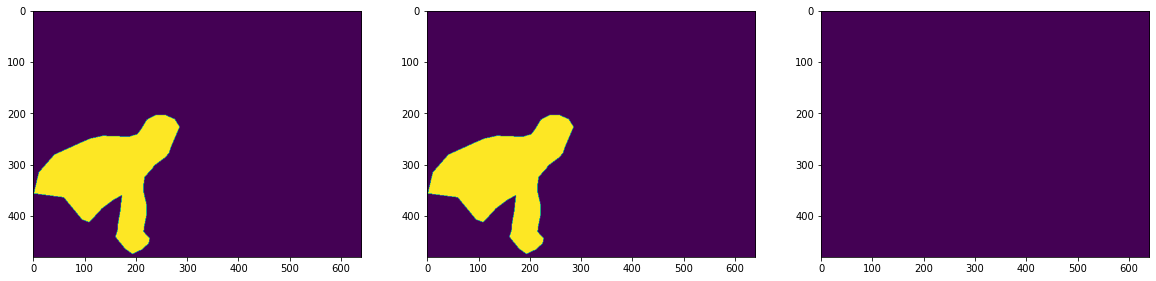

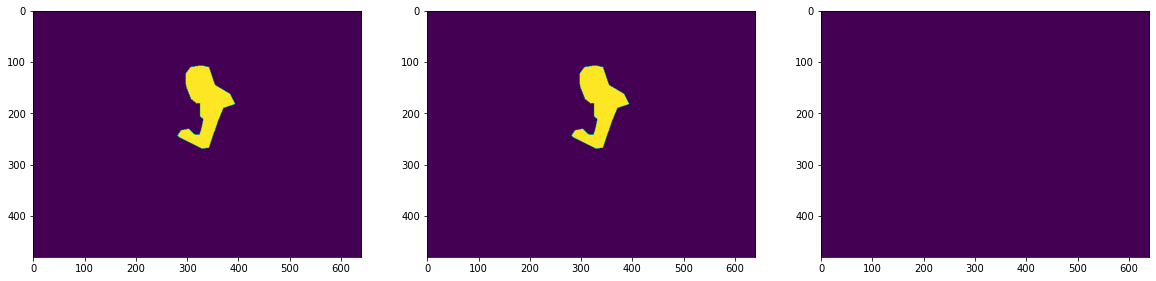

Error in callback <function flush_figures at 0x7f97ccf37378> (for post_execute):


KeyboardInterrupt: 

In [ ]:
all_mae = 0

for sara_list in masks:
    for mask in masks[sara_list]:
        # print(masks[sara_list][mask] - gt_masks[sara_list][mask])
        pred = masks[sara_list][mask]
        pred = np.array(pred, dtype=np.uint8)
        pred = cv2.threshold(pred, 0.5, 1, cv2.THRESH_BINARY)[1]

        gt = gt_masks[sara_list][mask]
        gt = np.array(gt, dtype=np.uint8)
        gt = cv2.threshold(gt, 0.5, 1, cv2.THRESH_BINARY)[1]

        temp_mae = mae(pred, gt)
        # plt.figure()
        # plt.subplot(131)
        # plt.imshow(pred)
        # plt.subplot(132)
        # plt.imshow(gt)
        # plt.subplot(133)
        # plt.imshow(pred - gt)
        all_mae += temp_mae
        # print()
        break

print(f'Average /mae: {all_mae / len(masks)}')